# Problème

On a une matrice QUBO de taille n, qui peut se traduire par la fonction d'énergie suivante:

$x\in{\{0,1\}^n}$ Vecteur de bits et  $q_{ij}\in \mathbb{R}$ Élément de la matrice Qubo

$$H(x) = \sum^n_i{q_{ii} x_i} + \sum^n_{i<j}{q_{ij} x_ix_j}$$


L'objectif est de minimiser $H(x)$, ce qui équivaut à trouver $x_0$ tel que 

$$\forall x \in {\{0, 1\}^n}, x \ne x_0 \implies  H(x) > H(x_0)$$

## Résolution avec un QPU Pasqal

Les ordinateurs de Pasqal permettent l'évolution du Hamiltonien d'un système quantique vers un Hamiltonien final.

On cherche donc à obtenir un Hamltonien similaire au $H(x)$ vu précédemment.

On peut obtenir un Hamiltonien de la forme suivant sur un QPU de Pasqal:

$$
H(x) = \hbar\sum_i{(\frac{\Omega}{2}\sigma^x_i - \delta \^n_i)} + \sum_{i<j}{\frac{C_6}{(R_{ij})^6}\^n_i\^n_j}
$$

La première somme correspond à l'énergie des atomes seuls, la deuxième correspond à l'énergie des interactions entre les atomes.

Ce notebook traite **uniquement** de la deuxième somme. On cherchera à obtenir l'égalité suivante:

$$
\sum_{i<j}{\frac{C_6}{(R_{ij})^6}\^n_i\^n_j} =  \sum_{i<j}{q_{ij} x_ix_j}$$
$$


$C_6$ est le coefficient d'interaction du QPU, sa valeur est constante.

$R_{ij}$ est la distance entre les atomes $i$ et $j$.

## Objectif du notebook

### Placer des atomes dans un espace 2D, de manière à modéliser approximativement les interactions voulues sur un QPU.
Le $\mu m$ est l'unité des coordonnées

Les atomes doivent être placés à moins de $50\mu m$ du centre, et chaque atome doit se trouver à plus de $4\mu m$ des autres atomes.

Les atomes qui interagissent entre eux doivent être séparés par une distance $R_{ij}$ (cf. formule précédente)

In [1]:
# Bibliothèques utilitaires
import numpy as np  # Opérations sur arrays
import matplotlib.pyplot as plt  # Affichage de graphiques
from scipy.spatial.distance import pdist, squareform, cdist  # Calcul de distances

# Fonctions locales
from src.utils import max_outer, clamp
#from src.qubo_to_register import (
#    hard_mapping,
#)  # Modélisation trop spécifique au problème actuel
from src.check_register import RegisterChecker  # Classe pour vérifier

In [2]:
def hard_mapping(
    n_lran : int, n_hran : int, max_dist : float = 50, blockade : float = 13.253644930249399, interaction_coeff : float = 5420158.53, target_weight : float = -1
):
    """ Specific implementation of qubo to register conversion, only works for Sopra Germany's qubo matrices

    Args:
        n_lran : number of LRANs
        n_hran : number of HRANs
        max_dist : Maximum allowed distance between points and (0, 0). Defaults to 50.
        blockade : Blockade radius. Defaults to 13.253644930249399.
        interaction_coeff : C6 in the formula. Defaults to 5420158.53.
        target_weight : Weight between incompatible qubits. Defaults to -1.

    Returns:
        _type_: _description_
    """
    max_dist -= blockade

    # Minimal distance between atoms
    min_dist_between_atoms = 4

    
    # Calculate optimal distance, following the formula:
    # Rij = (C_6 / weight)^(1/6)
    if target_weight > 0:
        inter_dist = clamp(
            (interaction_coeff / target_weight) ** (1 / 6),
            lower=4,
            upper=blockade,
        )
    # Check the number of lran that can be put on the outer circle
    max_lran = max_outer(max_dist, blockade, inter_dist)
    if n_lran > 2 * max_lran - 1:
        print(f"Cannot create more than {2 * max_lran - 1} lran")

    # Setup layers
    layers = []
    while n_lran > 0 and max_dist >= 0:
        layers.append((min(max_lran, n_lran), max_dist))
        max_dist -= 2 * blockade
        n_lran -= max_lran
        max_lran = max_outer(max_dist, blockade, inter_dist)

    # Place qubits on the array
    coords = []
    for n_lran, max_dist in layers:
        for i in range(n_lran):
            angle = i * 2 * np.pi / n_lran
            x = np.cos(angle) * (max_dist - 1)
            y = np.sin(angle) * (max_dist - 1)
            #coords.append([x, y])  # for visual purposes only

            #Maximum hran that can be put around the point of coordinate (x,y)  
            max_hran = (2*np.pi*blockade)//min_dist_between_atoms
            if n_hran > max_hran :
                #raise ValueError('Too much hran')
                print('Too much hran')

            for j in range(min(n_hran, max_hran)):
                jangle = angle + j * 2*np.pi / n_hran + np.pi / 2
                xj = x + np.cos(jangle) * inter_dist
                yj = y + np.sin(jangle) * inter_dist
                coords.append([xj, yj])
    return coords

#### Initialisation de l'évaluateur de mappings (Placements d'atomes)

In [3]:
with open("matrices/example.pkl", "rb") as f:
    qubo = np.load(f)
# plt.matshow(qubo)

check = RegisterChecker(qubo)

#### Exemple d'implémentation - Mapping spécifique au problème simplifié
Ne nécessite pas la matrice qubo en entrée mais ne fonctionne que pour un cas très spécifique

Faites `F12` ou regardez dans le fichier `src/qubo_to_register.py` pour voir le code

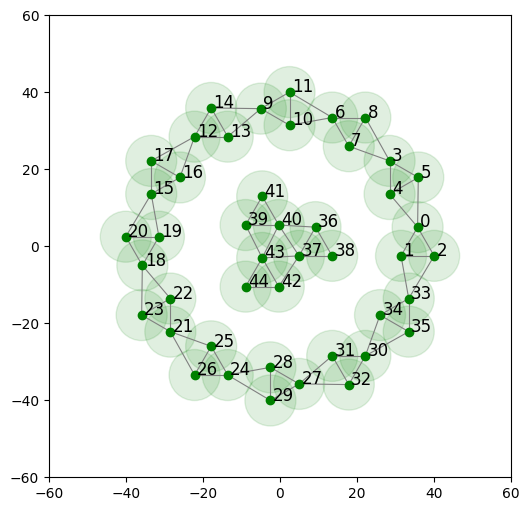

In [4]:
mapping = hard_mapping(
    n_lran=16,
    n_hran=3,
    blockade=check.blockade,
    interaction_coeff=check.C6,
    target_weight=qubo[0][1],
)
#check.evaluate_register(mapping)
check.show_register(mapping, shape=(6, 6))

#### Exemple d'implémentation - Boucle d'optimisation avec Scipy
Fonctionne en théorie pour n'importe quel problème QUBO, mais ne fonctionne juste pas

In [5]:
from scipy.optimize import minimize


def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    coords_dist = pdist(new_coords)
    too_close = False  # or np.min(coords_dist) < 4
    new_Q = squareform(
        check.C6 / coords_dist**6
    )  # + cdist(new_coords, np.zeros(shape))
    new_Q = new_Q - np.diag(np.diag(new_Q))
    too_far = False  # or np.max(cdist(new_coords, np.zeros(shape))) > 50
    diff_norm = np.linalg.norm(new_Q - Q - np.diag(np.diag(Q)))
    return diff_norm * (1 + too_far | too_close)


shape = (len(qubo), 2)
costs = []
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(qubo, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)

mapping = np.reshape(res.x, (len(qubo), 2))

Score : 34.38550366212352 %


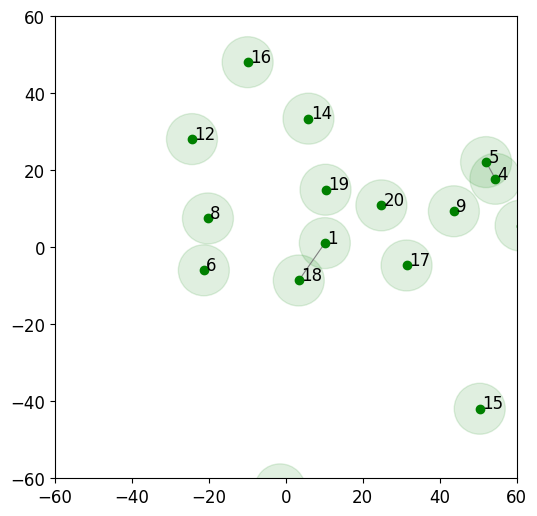

In [6]:
check.evaluate_register(mapping)
check.show_register(mapping, shape=(6, 6))

In [7]:
np.set_printoptions(formatter={"float_kind": "{:.1f}".format}, linewidth=999)
print(mapping)

[[-22.9 123.6]
 [10.2 1.1]
 [61.0 5.6]
 [73.8 -37.8]
 [54.5 17.8]
 [52.0 22.1]
 [-21.3 -6.0]
 [-1.5 -62.9]
 [-20.2 7.5]
 [43.7 9.4]
 [68.0 16.4]
 [142.6 -0.4]
 [-24.4 28.1]
 [77.6 100.0]
 [5.9 33.4]
 [50.4 -41.9]
 [-9.9 48.1]
 [31.4 -4.7]
 [3.4 -8.6]
 [10.3 14.9]
 [24.8 10.9]
 [-123.7 21.7]]


### Votre implémentation!
Implémentez une fonction qui place les atomes selon les contraintes spécifiées. Pour résumer:
- Distance(Atome, (0,0)) < 50
- Ditance(Atome, Atome) > 4
- Si les atomes $a_i$ et $a_j$ interagissent:
  > Distance($a_i$, $a_j$) $\thickapprox$ ($R_{ij}$)
- Sinon:
  > Distance($a_i$, $a_j$) > $blockade$

$$
R_{ij} = \left(\frac{C_6}{qubo[i][j]}\right)^{\frac{1}{6}}
$$

La manière d'implémenter la fonction est libre, vous pouvez vous baser sur mon implémentation (hard_mapping), l'implémentation avec l'optimiseur scipy ou même utiliser une bibliothèque externe pour vous faciliter la tâche.

In [8]:
import numpy as np
from scipy.optimize import minimize
import time

def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def penalty_function(positions, qubo, C6, blockade, n, max_dist_to_origin, min_dist_interatoms):
    penalty = 0
    positions = positions.reshape((n, 2))
    for i in range(n):
        for j in range(i + 1, n):
            dist_ij = distance(positions[i], positions[j])
            if qubo[i, j] != 0:
                Rij = (C6 / qubo[i, j])**(1/6)
                penalty += (dist_ij - Rij)**2
            else:
                if dist_ij < blockade:
                    penalty += (blockade - dist_ij)**2
    for i in range(n):
        dist_to_origin = distance(positions[i], (0, 0))
        if dist_to_origin >= max_dist_to_origin:
            penalty += (dist_to_origin - max_dist_to_origin)**2
        for j in range(i + 1, n):
            dist_ij = distance(positions[i], positions[j])
            if dist_ij < min_dist_interatoms:
                penalty += (min_dist_interatoms - dist_ij)**2
    return penalty

def place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms):
    start_time = time.time()
    n = qubo.shape[0]
    initial_positions = np.random.rand(n * 2) * 10  # Initial positions in the range [0, 10)

    result = minimize(penalty_function, initial_positions, args=(qubo, C6, blockade, n, max_dist_to_origin, min_dist_interatoms), method='L-BFGS-B')
    
    print("Time elapsed : ", time.time()-start_time)

    if result.success:
        final_positions = result.x.reshape((n, 2))
        return final_positions
    else:
        raise ValueError("Optimization failed")


In [9]:
#Exemple
qubo = np.array([[0, 1, 0.5], [1, 0, 0.2], [0.5, 0.2, 0]])
C6 = 5420158.53
blockade = 13.253644930249399
max_dist_to_origin = 50
min_dist_interatoms = 4

positions = place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms)
print("Positions des atomes :")
print(positions)

Time elapsed :  0.014137983322143555
Positions des atomes :
[[10.2 9.6]
 [1.7 -0.6]
 [-3.2 16.0]]


Time elapsed :  0.011643171310424805


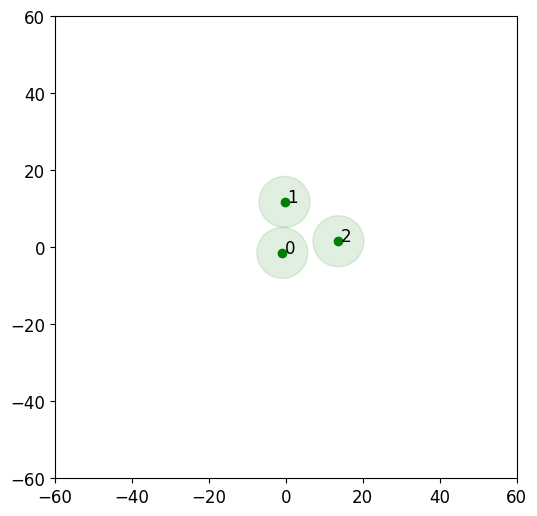

In [10]:
mapping = place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms)

#check.evaluate_register(mapping)
check.show_register(mapping, shape=(6, 6))

In [11]:
# Cette fonction sera appelée par la cellules de tests
# Vous pouvez changer les arguments de la fonction comme vous voulez, il faudra simplement adapter la cellule de tests plus tard
def find_mapping(qubo, C6=check.C6, blockade=check.blockade) -> np.array:
    # FIXME
    return place_atoms(qubo, C6, blockade, max_dist_to_origin, min_dist_interatoms)
  # TODO Ceci est un placeholder, il faut bien évidemment changer la valeur de retour

In [12]:
# Test rapide pour voir le mapping sous forme de matrice QUBO
check.map_to_qubo(find_mapping(check.qubo))

Time elapsed :  1.7168934345245361


array([[0.0, 360.0, 0.0, 0.1, 0.0, 0.0, 0.4, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0],
       [360.0, 0.0, 0.1, 0.2, 0.0, 0.0, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.1, 0.0, 360.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0],
       [0.1, 0.2, 360.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.5, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 360.0, 0.0, 0.0, 0.2, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 360.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0],
       [0.4, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 360.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 360.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.2,

#### Tests

Génération aléatoire de matricees à tester

In [13]:
# Génération de matrice QUBO aléatoire\
# size = nb de qubits
def generate_qubo(size=18):
    v = np.random.randint(1, 20, (size * (size - 1)) // 2) * np.random.rand()
    return squareform(v)


def save_matrix(mat, name):
    with open(
        f"./matrices/{name}.pkl", "wb"
    ) as f:  # Ajout de la matrice dans le dossier matrices/
        np.save(f, mat)


smol_random = generate_qubo(10)
print(smol_random)
save_matrix(smol_random, name="random")

[[0.0 7.7 3.9 3.9 0.5 4.8 6.8 2.4 2.4 4.4]
 [7.7 0.0 4.4 0.5 9.2 6.8 1.5 1.0 7.7 1.5]
 [3.9 4.4 0.0 1.5 4.4 8.7 7.3 3.9 1.0 4.4]
 [3.9 0.5 1.5 0.0 7.3 7.7 4.8 1.9 1.5 8.2]
 [0.5 9.2 4.4 7.3 0.0 2.9 9.2 8.2 6.3 2.9]
 [4.8 6.8 8.7 7.7 2.9 0.0 4.8 6.3 7.7 3.9]
 [6.8 1.5 7.3 4.8 9.2 4.8 0.0 4.4 8.7 1.9]
 [2.4 1.0 3.9 1.9 8.2 6.3 4.4 0.0 1.5 1.0]
 [2.4 7.7 1.0 1.5 6.3 7.7 8.7 1.5 0.0 6.8]
 [4.4 1.5 4.4 8.2 2.9 3.9 1.9 1.0 6.8 0.0]]


In [17]:
size =18
v = np.random.randint(1, 20, (size * (size - 1)) // 2) * np.random.rand()
print(v)

[10.1 4.3 1.4 1.4 13.7 0.7 5.1 0.7 10.8 13.0 10.8 4.3 3.6 10.8 1.4 9.4 12.3 10.8 7.9 2.2 12.3 5.1 2.2 4.3 7.9 8.7 6.5 7.2 9.4 9.4 3.6 4.3 0.7 10.1 2.9 5.1 10.1 10.8 7.9 13.0 2.2 6.5 11.6 13.7 4.3 2.2 9.4 9.4 0.7 2.9 5.1 8.7 11.6 8.7 3.6 2.9 9.4 10.8 13.0 13.0 5.1 6.5 9.4 9.4 10.1 3.6 0.7 1.4 11.6 11.6 5.8 3.6 5.1 13.0 13.0 2.9 12.3 9.4 4.3 6.5 7.2 3.6 2.2 6.5 4.3 9.4 2.9 7.2 12.3 12.3 1.4 13.7 10.1 5.8 4.3 2.2 12.3 5.8 1.4 5.8 7.9 12.3 5.8 11.6 4.3 1.4 0.7 12.3 1.4 9.4 5.8 4.3 5.1 7.9 3.6 2.9 5.1 11.6 10.1 12.3 4.3 13.7 13.0 8.7 2.9 7.2 7.9 13.7 5.8 1.4 4.3 10.8 9.4 13.0 9.4 11.6 1.4 4.3 8.7 5.8 1.4 1.4 8.7 12.3 10.8 13.7 4.3 10.8 5.8 13.0 5.1 5.8 2.9]


Cellule de test

Time elapsed :  1.793459415435791
Score : 76.11450520024805 %


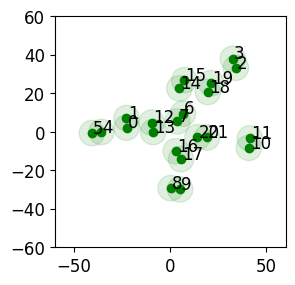

Time elapsed :  0.47653865814208984
Score : 78.42021329310836 %


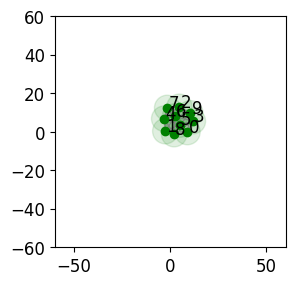

In [14]:
import os
from os.path import join, isfile

MANUAL_PICK = False  # True si on veut choisir les matrices à tester
SHOW_GRAPHS = True  # True si on veut voir le graphique pour chaque matrice testée
PATH = "./matrices/"


test_matrices = [
    join(PATH, f) for f in os.listdir("./matrices") if isfile(join(PATH, f))
]

if len(test_matrices) == 0 or MANUAL_PICK:
    test_matrices = ["random.pkl"]  # Choix manuel des matrices à tester
    test_matrices = [
        join(PATH, f) for f in test_matrices
    ]  # Formattage du chemin vers les matrices

for matrix_file in test_matrices:
    with open(matrix_file, "rb") as f:
        check.qubo = np.load(f)
    mapping = find_mapping(check.qubo)
    check.evaluate_register(mapping)
    if SHOW_GRAPHS:
        check.show_register(mapping, shape=(3, 3))